# EMI 2024 
## Escuela (de verano) en Métodos Iterativos

- The motivation

  3D simulations, HPC

- The actual motivation

  Upscale simulations, black-box never works

# The only requirement: Weak formulations

$$ -\Delta u = f \quad \Leftrightarrow \quad \int \nabla u \cdot \nabla v\,dx = \int f v\,dx \quad \forall v \in V_0$$

# Motivation problem: CFD

$$ \begin{aligned}-\Delta u + \nabla p = f\\ \mathrm{div}\, u = 0\end{aligned} \Leftrightarrow \begin{aligned}\int \nabla u\cdot \nabla v\,dx + \int p\, \mathrm{div}\, v\,dx && \forall v\in V \\ \int q \,\mathrm{div}\, u \,dx = 0 &&\forall q \in Q \end{aligned} \Leftrightarrow \begin{bmatrix} \mathbf{A} & \mathbf{B}^T \\ \mathbf{B} & \mathbf{0} \end{bmatrix}\begin{bmatrix} \mathbf{U} \\ \mathbf{P} \end{bmatrix} = \begin{bmatrix} \mathbf{F} \\ \mathbf{0} \end{bmatrix}$$

# Import and Geometry

In [1]:
from ngsolve import *
from ngsolve.krylovspace import GMResSolver
from ngsolve.webgui import Draw
from netgen.occ import *

shape = Rectangle(2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()
shape.edges.name="wall"
shape.edges.Min(X).name="inlet"
shape.edges.Max(X).name="outlet"
Draw (shape);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [2]:
geo = OCCGeometry(shape, dim=2)
mesh = Mesh(geo.GenerateMesh(maxh=0.05))
mesh.Curve(3)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [3]:
V = VectorH1(mesh, order=2, dirichlet="wall|inlet|cyl")
Q = H1(mesh, order=1)
X = V*Q
(u,p),(v,q) = X.TnT()

stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
#stokes = InnerProduct(Grad(u), Grad(v))*dx
a = BilinearForm(stokes)
f = LinearForm(v[0]*dx)
gf = GridFunction(X)
gfu, gfp = gf.components

uin = CF( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
Draw(gfu, mesh, min=0, max=2)
SetVisualization(max=2)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [4]:
#pre = Preconditioner(a, "local")
a.Assemble()
f.Assemble()
res = f.vec -a.mat * gf.vec
#inv = CGSolver(a.mat, pre.mat, precision=1e-6, printrates=True)
#GMResSolver(A=a.mat, pre=pre.mat, b=gf.vec, tol=1e-6, printrates=True, x=u.vec)
inv = a.mat.Inverse(freedofs=X.FreeDofs(), inverse="umfpack")
gf.vec.data += inv * res
#gf.vec.data += a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky") * res
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

Number of non-zeros of A: 110037
Number of non-zeros of L+U: 697406
Ratio of non-zeros: 0.15778040338052726


/usr/lib/python3/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:322: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


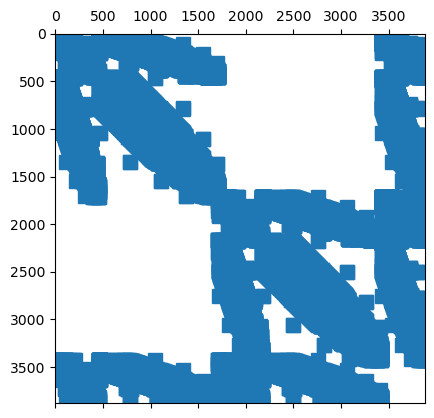

In [5]:
# Now we compute the nonzeros in the LU factorization

rows,cols,vals = a.mat.COO()
print("Number of non-zeros of A:", len(vals))

import scipy.sparse as sp
A = sp.csr_matrix((vals,(rows,cols)))
from scipy.sparse.linalg import splu # Sparse LU

LU= splu(A)
nnzs = LU.L.nnz + LU.U.nnz
print("Number of non-zeros of L+U:", nnzs)
print("Ratio of non-zeros:", len(vals)/nnzs)
import matplotlib.pylab as plt
plt.spy(A)
plt.show()


In [6]:
import matplotlib.pylab as plt
def computeNonzeros(maxh):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(3)
    V = VectorH1(mesh, order=2, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=1)
    X = V*Q
    (u,p),(v,q) = X.TnT()
    
    stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
    a = BilinearForm(stokes)
    a.Assemble()
    rows,cols,vals = a.mat.COO()
    nnzA = len(vals)
    print("Number of non-zeros of A:", len(vals))
    
    import scipy.sparse as sp
    A = sp.csr_matrix((vals,(rows,cols)))
    from scipy.sparse.linalg import splu # Sparse LU
    
    LU= splu(A)
    nnzs = LU.L.nnz + LU.U.nnz
    print("Number of non-zeros of L+U:", nnzs)
    print("Ratio of non-zeros:", len(vals)/nnzs)
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    # ax1.spy(A)
    # ax2.spy(LU.L)
    # ax3.spy(LU.U)
    # plt.show()
    return nnzA, nnzs

def convertToMb(val):
    return val * 8 * 1e-6

for h in [0.1, 0.05, 0.01]:
    print("=======================")
    print(f"Using h={h:1.3f}")
    nnza, nnzlu = computeNonzeros(h)
    memA = convertToMb(nnza)
    memLU = convertToMb(nnzlu)
    print(f"Memoria para A:  {memA:.2f}M")
    print(f"Memoria para LU: {memLU:.2f}M")

Using h=0.100
Number of non-zeros of A: 35186
Number of non-zeros of L+U: 145841
Ratio of non-zeros: 0.24126274504426054
Memoria para A:  0.28M
Memoria para LU: 1.17M
Using h=0.050
Number of non-zeros of A: 110037
Number of non-zeros of L+U: 697406
Ratio of non-zeros: 0.15778040338052726
Memoria para A:  0.88M
Memoria para LU: 5.58M
Using h=0.010


/usr/lib/python3/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:322: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of non-zeros of A: 2461830
Number of non-zeros of L+U: 54514015
Ratio of non-zeros: 0.045159579605354695
Memoria para A:  19.69M
Memoria para LU: 436.11M


In [ ]:
from time import perf_counter
def solveDirect(maxh):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(3)
    V = VectorH1(mesh, order=2, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=1)
    X = V*Q
    (u,p),(v,q) = X.TnT()
    
    stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
    #stokes = InnerProduct(Grad(u), Grad(v))*dx
    a = BilinearForm(stokes)
    f = LinearForm(v[0]*dx)
    gf = GridFunction(X)
    gfu, gfp = gf.components
    
    uin = CF( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
    
    gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
    a.Assemble()
    f.Assemble()
    t0 = perf_counter()
    inv = a.mat.Inverse(inverse="umfpack")
    gf.vec.data += inv * f.vec
    tf = perf_counter() - t0
    return tf

def solveIterative(maxh):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(3)
    V = VectorH1(mesh, order=1, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=1)
    
    u,v = V.TnT()
    p,q = Q.TnT()

    
    a = BilinearForm(InnerProduct(Grad(u),Grad(v))*dx, symmetric=True)
    b = BilinearForm(div(u)*q*dx).Assemble()
    h = specialcf.mesh_size
    c = BilinearForm(-0.1*h*h*grad(p)*grad(q)*dx, symmetric=True).Assemble()
    
    mp = BilinearForm(p*q*dx, symmetric=True)
    f = LinearForm(V).Assemble()
    g = LinearForm(Q).Assemble();
    gfu = GridFunction(V, name="u")
    gfp = GridFunction(Q, name="p")
    uin = CoefficientFunction( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
    gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
    
    
    Qjacobi = Preconditioner(mp, "local")
    Amg = Preconditioner(a, "h1amg")
    a.Assemble()
    mp.Assemble()
    K = BlockMatrix( [ [a.mat, b.mat.T], [b.mat, c.mat] ] )
    #C = BlockMatrix( [ [Amg.mat, None], [None, Qjacobi.mat] ] )
    C = BlockMatrix( [ [a.mat.Inverse(freedofs=V.FreeDofs()), None], [None, mp.mat.Inverse()] ] )
    
    rhs = BlockVector ( [f.vec, g.vec] )
    sol = BlockVector( [gfu.vec, gfp.vec] )
    t0 = perf_counter()
    solvers.MinRes (mat=K, pre=C, rhs=rhs, sol=sol, printrates='\r', initialize=False, maxsteps=500);
    #solvers.GMRes (K, rhs, pre=C, x=sol, printrates='\n', tol=1e-6, maxsteps=500);
    
    tf = perf_counter() - t0
    return tf

maxh = 0.01
tfds = []
tfis = []
maxhs = [0.1, 0.05, 0.01]
for maxh in maxhs:
    print("============")
    print(f"Solving for h={maxh:1.3f}")
    tfd = solveDirect(maxh)
    tfi =solveIterative(maxh)
    tfis.append(tfi)
    tfds.append(tfd)

Solving for h=0.100
LinearSolver converged in 93 iterations to residual 3.09314858071696e-07
Solving for h=0.050
LinearSolver converged in 98 iterations to residual 3.2063366223913405e-07
Solving for h=0.010


In [ ]:
plt.loglog(maxhs, tfis, label="Iterative")
plt.loglog(maxhs, tfds, label="Direct")
plt.legend()
plt.show()